# TOC

__Chapter 4 - Feature construction__

1. [Import](#Import)
1. [Feature construction](#Feature-construction)
    1. [Imputing categorical features](#Imputing-categorical-features)
    1. [Encoding categorical values](#Encoding-categorical-values)
        1. [Encoding at the nominal level](#Encoding-at-the-nominal-level)
        1. [Encoding at the ordinal level](#Encoding-at-the-ordinal-level)
    1. [Bucketing numeric features into categories](#Bucketing-numeric-features-into-categories)
    1. [Pipeline - putting it all together](#Pipeline-putting-it-all-together)
1. [Extending numerical features](#Extending-numerical-features)
    1. [Polynomial features](#Polynomial-features)

# Import

<a id = 'Import'></a>

In [1]:
# standard libary and settings
import os
import sys
import importlib
import itertools
import warnings

warnings.simplefilter("ignore")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
import sklearn.preprocessing as preprocessing
import sklearn.pipeline as pipeline
import sklearn.neighbors as neighbors
import sklearn.model_selection as model_selection
import sklearn.base as base
import sklearn.impute as impute

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt

# magic functions
%matplotlib inline

In [2]:
# create dummy data
X = pd.DataFrame(
    {
        "city": ["tokyo", None, "london", "seattle", "san francisco", "tokyo"],
        "boolean": ["yes", "no", None, "no", "no", "yes"],
        "ordinal_column": [
            "somewhat like",
            "like",
            "somewhat like",
            "like",
            "somewhat like",
            "dislike",
        ],
        "quantitative_column": [1, 11, -0.5, 10, None, 20],
    }
)
display(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.000000
1,None,no,like,11.000000
2,london,None,somewhat like,-0.500000
3,seattle,no,like,10.000000
4,san francisco,no,somewhat like,nan
5,tokyo,yes,dislike,20.000000


# Feature construction

<a id = 'Feature-construction'></a>

In [3]:
# count nulls by columns
X.isnull().sum()

city                   1
boolean                1
ordinal_column         0
quantitative_column    1
dtype: int64

## Imputing categorical features

Imputer() can be used to fill nulls in categorical features, but first requires that values be encoded as integer. Imputer() fills categorical nulls with the most frequent value, but a custom transformer can be used to apply more nuance.

<a id = 'Imputing-categorical-features'></a>

In [4]:
# return most frequent value in city
X["city"].value_counts().index[0]

'tokyo'

In [5]:
# fill nulls with the most frequent value
X["city"].fillna(X["city"].value_counts().index[0])

0            tokyo
1            tokyo
2           london
3          seattle
4    san francisco
5            tokyo
Name: city, dtype: object

In [6]:
# build custom object to perform this task
class CustomCategoryImputer(base.TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols

    def fit(self, X, y=None):
        return self

    def transform(self, df):
        #         x = df.copy()
        for col in self.cols:
            X[col].fillna(X[col].value_counts().index[0], inplace=True)
        return X

In [7]:
# implement custom imputer
cci = CustomCategoryImputer(cols=["city", "boolean"])
cci.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.000000
1,tokyo,no,like,11.000000
2,london,no,somewhat like,-0.500000
3,seattle,no,like,10.000000
4,san francisco,no,somewhat like,nan
5,tokyo,yes,dislike,20.000000


In [8]:
# custom object for imputing quantitative variables
class CustomQuantitativeImputer(base.TransformerMixin):
    def __init__(self, cols=None, strategy="mean"):
        self.cols = cols
        self.strategy = strategy

    def fit(self, X, y=None):
        return self

    def transform(self, df):
        X = df.copy()
        imputed = impute.SimpleImputer(missing_values=np.nan, strategy=self.strategy)
        for col in self.cols:
            X[col] = imputed.fit_transform(X[[col]])
        return X

In [9]:
# impute quantitative variables
cqi = CustomQuantitativeImputer(strategy="median", cols=["quantitative_column"])
cqi.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.000000
1,tokyo,no,like,11.000000
2,london,no,somewhat like,-0.500000
3,seattle,no,like,10.000000
4,san francisco,no,somewhat like,10.000000
5,tokyo,yes,dislike,20.000000


In [10]:
# cCombine into pipeline
imputer = pipeline.Pipeline([("category", cci), ("quant", cqi)])
imputer.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.000000
1,tokyo,no,like,11.000000
2,london,no,somewhat like,-0.500000
3,seattle,no,like,10.000000
4,san francisco,no,somewhat like,10.000000
5,tokyo,yes,dislike,20.000000


## Encoding categorical values

<a id = 'Encoding-categorical-values'></a>

### Encoding at the nominal level

pd.get_dummies() mimics OneHotEncoding 

<a id = 'Encoding-at-the-nominal-level'></a>

In [11]:
# create dummy columns
pd.get_dummies(X, columns=["city", "boolean"], prefix_sep="__")

,ordinal_column,quantitative_column,city__london,city__san francisco,city__seattle,city__tokyo,boolean__no,boolean__yes
0,somewhat like,1.000000,0,0,0,1,0,1
1,like,11.000000,0,0,0,1,1,0
2,somewhat like,-0.500000,1,0,0,0,1,0
3,like,10.000000,0,0,1,0,1,0
4,somewhat like,nan,0,1,0,0,1,0
5,dislike,20.000000,0,0,0,1,0,1


In [12]:
# custom object for performing get dummies on select features
class CustomDummifier(base.TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols

    def transform(self, X):
        return pd.get_dummies(X, columns=self.cols, prefix="__")

    def fit(self, *_):
        return self

In [13]:
# create dummy columns using custom class
cd = CustomDummifier(cols=["city", "boolean"])
cd.fit_transform(X)

,ordinal_column,quantitative_column,___london,___san francisco,___seattle,___tokyo,___no,___yes
0,somewhat like,1.000000,0,0,0,1,0,1
1,like,11.000000,0,0,0,1,1,0
2,somewhat like,-0.500000,1,0,0,0,1,0
3,like,10.000000,0,0,1,0,1,0
4,somewhat like,nan,0,1,0,0,1,0
5,dislike,20.000000,0,0,0,1,0,1


### Encoding at the ordinal level


<a id = 'Encoding-at-the-ordinal-level'></a>

In [14]:
# display ordinal column prior to transformation
print(X["ordinal_column"])

0    somewhat like
1             like
2    somewhat like
3             like
4    somewhat like
5          dislike
Name: ordinal_column, dtype: object


In [15]:
# display ordinaly column with encoding
ordering = ["dislike", "somewhat like", "like"]
print(X["ordinal_column"].map(lambda x: ordering.index(x)))

0    1
1    2
2    1
3    2
4    1
5    0
Name: ordinal_column, dtype: int64


In [16]:
# custom class
class CustomEncoder(base.TransformerMixin):
    def __init__(self, col, ordering=None):
        self.ordering = ordering
        self.col = col

    def transform(self, df):
        X = df.copy()
        X[self.col] = X[self.col].map(lambda x: self.ordering.index(x))
        return X

    def fit(self, *_):
        return self

In [17]:
# encode the ordinal column
ce = CustomEncoder(col="ordinal_column", ordering=["dislike", "somewhat like", "like"])
ce.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,1,1.000000
1,tokyo,no,2,11.000000
2,london,no,1,-0.500000
3,seattle,no,2,10.000000
4,san francisco,no,1,nan
5,tokyo,yes,0,20.000000


## Bucketing numeric features into categories

<a id = 'Bucketing-numeric-features-into-categories'></a>

In [18]:
# display the sample quantitative column
X["quantitative_column"]

0    1.000000
1   11.000000
2   -0.500000
3   10.000000
4         nan
5   20.000000
Name: quantitative_column, dtype: float64

In [19]:
# bin the quantitative column
pd.cut(X["quantitative_column"], bins=3)

0     (-0.52, 6.333]
1    (6.333, 13.167]
2     (-0.52, 6.333]
3    (6.333, 13.167]
4                NaN
5     (13.167, 20.0]
Name: quantitative_column, dtype: category
Categories (3, interval[float64]): [(-0.52, 6.333] < (6.333, 13.167] < (13.167, 20.0]]

In [20]:
# cut using labels = False, which returns the integer indicators of the bins
pd.cut(X["quantitative_column"], bins=3, labels=False)

0   0.000000
1   1.000000
2   0.000000
3   1.000000
4        nan
5   2.000000
Name: quantitative_column, dtype: float64

In [21]:
# custom class
class CustomCutter(base.TransformerMixin):
    def __init__(self, col, bins, labels=False):
        self.labels = labels
        self.bins = bins
        self.col = col

    def transform(self, df):
        X = df.copy()
        X[self.col] = pd.cut(X[self.col], bins=self.bins, labels=self.labels)
        return X

    def fit(self, *_):
        return self

In [22]:
# turns feature into an ordinal column
cc = CustomCutter(col="quantitative_column", bins=3)
cc.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,0.000000
1,tokyo,no,like,1.000000
2,london,no,somewhat like,0.000000
3,seattle,no,like,1.000000
4,san francisco,no,somewhat like,nan
5,tokyo,yes,dislike,2.000000


## Pipeline - putting it all together

<a id = 'Pipeline-putting-it-all-together'></a>

In [23]:
# create preprocessing pipeline
pipe = pipeline.Pipeline(
    [("quant", cqi), ("category", cci), ("dummies", cd), ("encode", ce), ("cut", cc)]
)

In [24]:
# data prior to pipeline
display(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.000000
1,tokyo,no,like,11.000000
2,london,no,somewhat like,-0.500000
3,seattle,no,like,10.000000
4,san francisco,no,somewhat like,nan
5,tokyo,yes,dislike,20.000000


In [25]:
# data after to pipeline
pipe.fit(X)
pipe.transform(X)

,ordinal_column,quantitative_column,___london,___san francisco,___seattle,___tokyo,___no,___yes
0,1,0.000000,0,0,0,1,0,1
1,2,1.000000,0,0,0,1,1,0
2,1,0.000000,1,0,0,0,1,0
3,2,1.000000,0,0,1,0,1,0
4,1,nan,0,1,0,0,1,0
5,0,2.000000,0,0,0,1,0,1


# Extending numerical features

<a id = 'Extending-numerical-features'></a>

In [27]:
# load and inspect data
df = pd.read_csv("s3://tdp-ml-datasets/misc/activity_recognizer_1.csv", header=None)
df.columns = ["index", "x", "y", "z", "activity"]
df[:5]

,index,x,y,z,activity
0,0.000000,1502,2215,2153,1
1,1.000000,1667,2072,2047,1
2,2.000000,1611,1957,1906,1
3,3.000000,1601,1939,1831,1
4,4.000000,1643,1965,1879,1


In [28]:
# the goal is to recognize observations where the activity is 7 vs. all others
# 7 corresponds to 'working at computer', whereas 1-6 correspond to some kind of moving activity
df["activity"].value_counts(normalize=True)

7   0.515369
1   0.207242
4   0.165291
3   0.068793
5   0.019637
6   0.017951
2   0.005711
0   0.000006
Name: activity, dtype: float64

In [29]:
# baseline model
X = df[["x", "y", "z"]]
y = df["activity"]

params = {"n_neighbors": [3, 4, 5, 6]}
knn = neighbors.KNeighborsClassifier()
grid = model_selection.GridSearchCV(knn, params)
grid.fit(X, y)

print(grid.best_score_)
print(grid.best_params_)

0.720752487676999
{'n_neighbors': 5}


## Polynomial features

<a id = 'Polynomial-features'></a>

In [30]:
# add polynomial features
poly = preprocessing.PolynomialFeatures(
    degree=2, include_bias=False, interaction_only=False
)
X_poly = poly.fit_transform(X)
X_poly.shape

(162501, 9)

In [31]:
# review transformed data
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head()

,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
0,"1,502.000000","2,215.000000","2,153.000000","2,256,004.000000","3,326,930.000000","3,233,806.000000","4,906,225.000000","4,768,895.000000","4,635,409.000000"
1,"1,667.000000","2,072.000000","2,047.000000","2,778,889.000000","3,454,024.000000","3,412,349.000000","4,293,184.000000","4,241,384.000000","4,190,209.000000"
2,"1,611.000000","1,957.000000","1,906.000000","2,595,321.000000","3,152,727.000000","3,070,566.000000","3,829,849.000000","3,730,042.000000","3,632,836.000000"
3,"1,601.000000","1,939.000000","1,831.000000","2,563,201.000000","3,104,339.000000","2,931,431.000000","3,759,721.000000","3,550,309.000000","3,352,561.000000"
4,"1,643.000000","1,965.000000","1,879.000000","2,699,449.000000","3,228,495.000000","3,087,197.000000","3,861,225.000000","3,692,235.000000","3,530,641.000000"


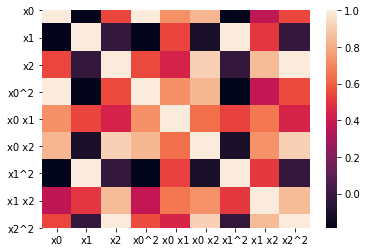

In [32]:
# display correlation heatmap
sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr())

In [33]:
# interaction terms only
poly = preprocessing.PolynomialFeatures(
    degree=2, include_bias=False, interaction_only=True
)
X_poly = poly.fit_transform(X)
X_poly.shape

(162501, 6)

In [34]:
# review transformed data
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head()

,x0,x1,x2,x0 x1,x0 x2,x1 x2
0,"1,502.000000","2,215.000000","2,153.000000","3,326,930.000000","3,233,806.000000","4,768,895.000000"
1,"1,667.000000","2,072.000000","2,047.000000","3,454,024.000000","3,412,349.000000","4,241,384.000000"
2,"1,611.000000","1,957.000000","1,906.000000","3,152,727.000000","3,070,566.000000","3,730,042.000000"
3,"1,601.000000","1,939.000000","1,831.000000","3,104,339.000000","2,931,431.000000","3,550,309.000000"
4,"1,643.000000","1,965.000000","1,879.000000","3,228,495.000000","3,087,197.000000","3,692,235.000000"


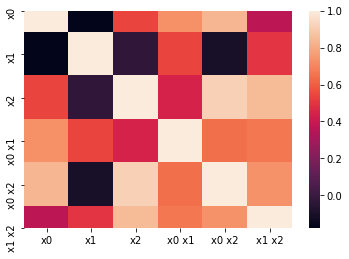

In [35]:
# display correlation heatmap
sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr())

In [36]:
# grid search over preprocessing steps and K nearest neighbors
params = {
    "poly_features__degree": [1, 2, 3],
    "poly_features__interaction_only": [True, False],
    "classify__n_neighbors": [3, 4, 5, 6],
}
pipe = pipeline.Pipeline([("poly_features", poly), ("classify", knn)])
model_selection.GridSearchCV(pipe, params)
grid.fit(X, y)

print(grid.best_score_, grid.best_params_)

0.720752487676999 {'n_neighbors': 5}
